# <center> R5.A.11 Méthodes d'optimisation <br> TP3 - Clustering </center>
<center> 2024/2025 - Thibault Godin & Tom Ferragut </center>
<center> IUT de Vannes, BUT Informatique </center>

# Clustering en 2 dimensions


On part d'un ensemble de points $(x_1,x_2,...,x_n)$, dans un espace 2D réel.

Le but de l'algorithme __k-means__ est de partitionner ces $n$ points en $k$ sous-ensembles $S_1, ..., S_k$ tel que la somme des distances à l'intérieur d'un cluster


$$ \sum_{i=1}^{k} \; \sum_{x_j \in S_i} \;  \left\|x_j -  μ_i  \right\|^2$$

soit minimale. Ici, les $μ_i$ désignent les _centroïdes_ (les barycentres des clusters).


Dans ce TP, on va implémenter cet algorithme.

### imports


In [27]:
import numpy as np

# Affichage graphique
#%matplotlib notebook
%matplotlib inline
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# heatmaps

import seaborn as sns
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]


## 1 - Données test & implémentation du clustering
On construit artificiellement un ensemble de données se prétant bien au clustering (i.e. dont le partitionnement est évident).  
Le but est de tester notre algorithme avec ces données avant de passer au monde réel.  
La fonction `clusters` génère des données favorables.

>__Question 1__ : Expliquer son fonctionnement en commentant le code.


In [28]:
nclusters = 5  # nombre souhaité de clusters
sizes = 50 * np.ones(nclusters, int)  # taille de chaque cluster


def clusters_func(sizes, min=-50, max=50, var=2.5):
    """
    creates a set of clusters whose sizes are given, centered around points which are memorized
    sizes : vecteur de k tailles de cluster (k le nombre de clusters)
    min, max : bornes pour la génération aléatoire des centres de clusters
    var : variance des points autour de chaque centre
    """
    
    np.random.seed(42)
    nbclusters = sizes.shape[0]  # Nombre de clusters qui donne la taille de chaque cluster
    clusters = []  # Liste qui va contenir les points de chaque cluster
    centers = []  # Liste des centres des clusters

    for i in range(nbclusters):
        x, y=np.random.uniform(min, max, 2)  # Génère aléatoirement un centre (x, y) dans la plage donnée
        
        centers.append((x, y))  # Ajoute ce centre à la liste des centres
        clusters.append([]) 
        for j in range(sizes[i]):
            xx = np.random.normal(x, var)
            yy = np.random.normal(y, var)
            clusters[i].append((xx, yy))  # Ajoute un point autour du centre (x, y) à la liste du cluster i
            # clusters[i] est une liste de points (x, y) appartenant au cluster i
    clusters=np.asarray(clusters)  # Transforme la liste de clusters en tableau numpy
    centers=np.asarray(centers)
    return [clusters, centers]

clusters, centers = clusters_func(sizes)

data = np.reshape(clusters, (-1, clusters.shape[-1]))


print("clusters.shape :", clusters.shape)

print("data.shape :", data.shape)


print("centers :", centers)

print("clusters[0] :", clusters[0]) 
print("data[0] :", data[0]) 


clusters.shape : (5, 50, 2)
data.shape : (250, 2)
centers : [[-12.54598812  45.07143064]
 [-38.01346327 -16.23848286]
 [-14.05088488 -20.64081557]
 [-12.79819142  27.64129607]
 [ 45.40510273  10.61746345]]
clusters[0] : [[-10.92676677  48.87900528]
 [-13.13137155  44.48608825]
 [ -8.59795608  46.99001746]
 [-13.71967408  46.42783075]
 [-13.70453235  43.90710626]
 [-11.94108244  40.28823003]
 [-16.8582827   43.66571182]
 [-15.07806592  45.85704897]
 [-14.8160483   41.54067139]
 [ -8.88186619  44.50698989]
 [-12.3771676   41.50956018]
 [-13.90694493  45.34873712]
 [-15.42347206  46.01067569]
 [-14.04758484  44.34219627]
 [-14.05025465  49.7021261 ]
 [-12.57973118  42.42715332]
 [-10.48962584  42.01932152]
 [-12.02382913  40.17225533]
 [-15.86645324  45.56358373]
 [-10.69982167  45.49985134]
 [-12.83510882  44.3186714 ]
 [-16.24229309  43.27182012]
 [-13.69758504  47.71423621]
 [-11.68694239  40.66383025]
 [-11.73577819  44.10872494]
 [-14.23829312  46.60062136]
 [ -9.96848931  47.3996309

On trace maintenant les données générées.


Text(0, 0.5, 'y')

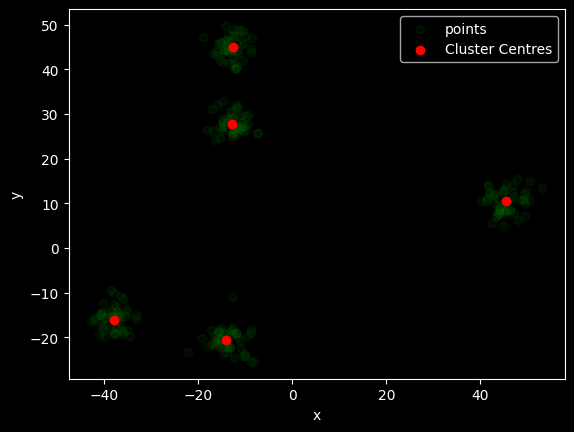

In [29]:
plt.close()

x = [data[i][0] for i in range(data.shape[0])]
y = [data[i][1] for i in range(data.shape[0])]

xc = [centers[i][0] for i in range(centers.shape[0])]
yc = [centers[i][1] for i in range(centers.shape[0])]

plt.scatter(x, y, color="g", label="points", alpha=0.1)
plt.scatter(xc, yc, color="r", label="Cluster Centres")
plt.legend(loc="upper right", fancybox=True)
plt.xlabel("x")
plt.ylabel("y")


>**Question 2**
>
>1. On commence l'algorithme k-means en choisissant $k$ centroïdes initiaux au hasard. Ecrire une fonction effectuant cette initialisation.
>
>2. Une variation simple mais permettant souvent d'accelerer le convergence est de choisir les centroïdes initiaux parmi les données. Écrire une fonction effectuant cette variante. _Attention à ne pas tirer deux fois le même point !_

In [30]:
   
    
def init_centroid_hasard(k, min=-50, max=50):
    """
    picks k random points
    """

    np.random.seed(42)
    centroids = np.random.uniform(min, max, (k, 2))
    return centroids

init=init_centroid_hasard(5)
print(init)


def init_centroid_donnees(k, data):
    """
    picks k random points among data
    """
    
    np.random.seed(42)
    indices = np.random.choice(data.shape[0], k, replace=False)
    centroids = data[indices]
    return centroids

init=init_centroid_donnees(5, data)
print(init)


[[-12.54598812  45.07143064]
 [ 23.19939418   9.86584842]
 [-34.39813596 -34.40054797]
 [-44.19163878  36.61761458]
 [ 10.11150117  20.80725778]]
[[-14.5711905  -21.87331791]
 [-16.8582827   43.66571182]
 [-37.86794147 -19.0959086 ]
 [-36.54632053 -10.7623438 ]
 [-15.87680146 -20.0996691 ]]


On trace les données en ajoutant les centroides tirés au hasard.

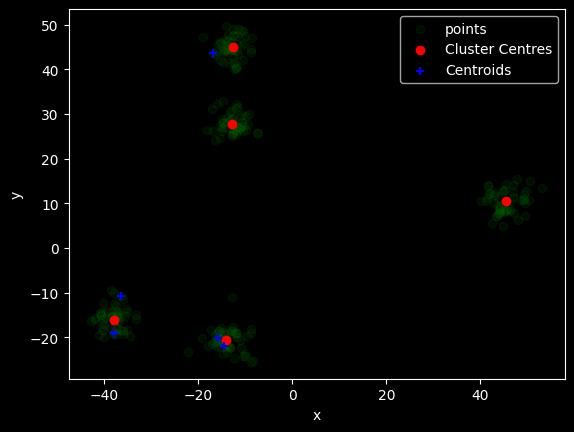

In [31]:

x = [data[i][0] for i in range(data.shape[0])]
y = [data[i][1] for i in range(data.shape[0])]

xc = [centers[i][0] for i in range(len(centers))]
yc = [centers[i][1] for i in range(len(centers))]

xct=[init[i][0] for i in range(len(init))]
yct=[init[i][1] for i in range(len(init))]

plt.scatter(x, y, color="g", label="points", alpha=0.1)
plt.scatter(xc, yc, color="r", label="Cluster Centres")
plt.scatter(xct, yct, marker="+", color="b", label="Centroids")

plt.legend(loc="upper right", fancybox=True)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


>**Question 3**
>
>Une des parties clef de l'algorithme des kmeans est de mettre à jour les centroïdes en prenant le barycentre des points d'une région (i.e. la moyenne des coordonnées). <br>
Écrire une fonction `centroid_update(cluster)` effectuant le calcul du nouveau centroide du cluster en paramètre

In [32]:

def distance(p1, p2):
    """
    Computes the (euclidian) distance between p1 and p2
    """
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def centroid_update(cluster):
    """
    Computes the middle point among a cluster
    """
    cluster = np.asarray(cluster)
    if len(cluster) == 0:
        return (0, 0)
    centroid_x = np.mean(cluster[:, 0])
    centroid_y = np.mean(cluster[:, 1])
    return (centroid_x, centroid_y)

centroid_update(data)


(np.float64(-6.4126042055352395), np.float64(9.340333763789475))

On défini maintenant l'algorithme principal : à chaque tour, 

1) chaque point est assigné au centroïde le plus proche (ce qui permet de définir des "régions")

2) on calcule les nouveaux centroïdes, en prennant le barycentre de chaque région.

On s'arrête quand les centroïdes n'évoluent plus beaucoup (différence entre deux centroides successifs inférieure à $10^{-3}$ par exemple).

>**Question 4**
>
>
>Écrire une fonction <tt>regions_update</tt> qui place chaque point dans la région du centroïde le plus proche. Cette fonction renvoie une liste 
>
>
>_visualisation :_
>Tracer les points d'une même région dans une seule couleur, différente pour chaque région.

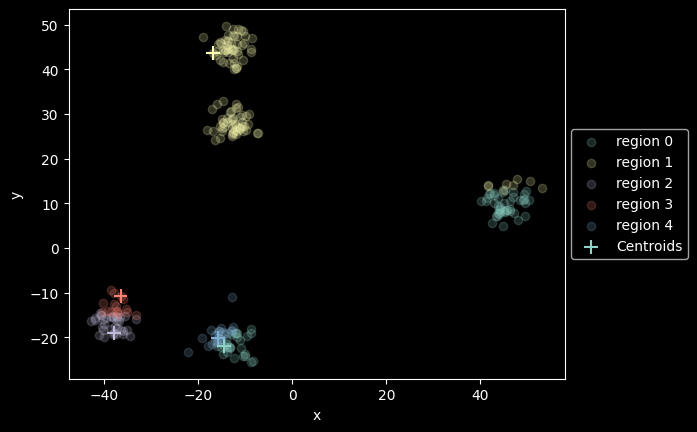

In [33]:
k = 5
def regions_update(k, data, centroids):
    regions = [[] for i in range(k)]

    for point in data:
        distances = [distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        regions[closest_centroid].append(point)
    
    return regions


#init = init_centroid_hasard(5, data)
init=init_centroid_donnees(5, data)

regions = regions_update(k, data, init)


for i in range(len(regions)):
    xr=[regions[i][j][0] for j in range(len(regions[i]))]
    yr=[regions[i][j][1] for j in range(len(regions[i]))]
    label = "region " + str(i)
    plt.scatter(xr, yr, alpha=0.2, label=label)

xct=[init[i][0] for i in range(len(init))]
yct=[init[i][1] for i in range(len(init))]
#plt.scatter(xc, yc, color='r', label="Cluster Centres")
plt.scatter(xct, yct, s=100, marker="+", c=cycle[:len(xct)], label="Centroids")  
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("x")
plt.ylabel("y")
plt.show()


>**Question 5**
>
>Écrire une fonction <tt>centroids_update</tt> qui actualise les centroïdes au barycentres des régions (en >utilisantcentroid_update comme sous fonction).
>
>_remarque_ attention, une région peut être vide. Dans ce cas il convient de choisir un point au hasard pour l'actualisation.
>
>
>_visualisation :_
>Tracer l'évolution des centroïdes.

Nouveaux centroïdes :
 [[ 22.81764456  -2.6538716 ]
 [ -8.44404132  34.72812047]
 [-38.41350727 -17.01403447]
 [-37.40926353 -13.0528401 ]
 [-15.69585215 -19.3527746 ]]
Déplacement maximal :
 42.039411313920155


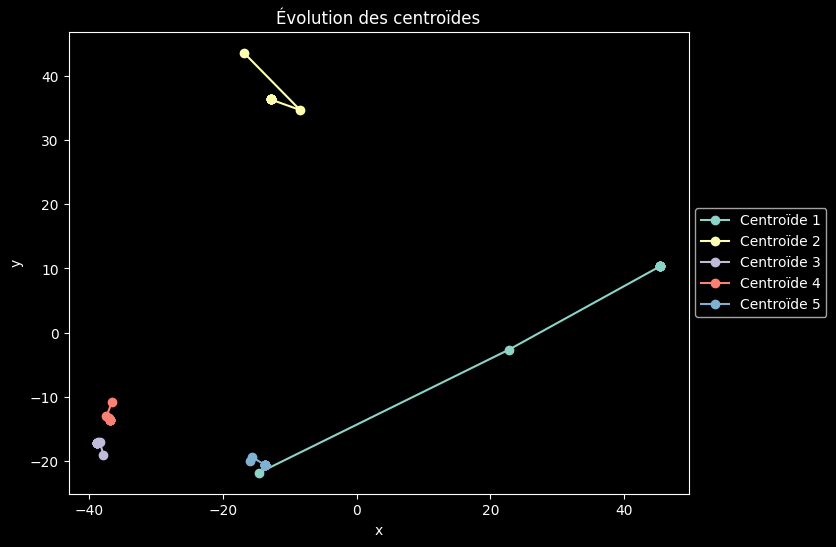

In [34]:
def centroids_update(data,centroids,regions):
    """
    Actualise les centroïdes
    
    INPUTS:
    data (array): données
    centroids (array): ancien centroïdes
    regions (array): partionnement des donnée
    
    OUTPUTS
    centroids (array): nouveaux centroïdes
    diff (foat): distance maximale de déplacement d'un centroïde lors de l'actualisation
    
    """
    centroids_new = []
    diffs = []
    
    for i in range(len(centroids)):
        if len(regions[i]) == 0:
            new_centroid = data[np.random.randint(0, len(data))]
        else:
            new_centroid = np.mean(regions[i], axis=0)

        diff = distance(centroids[i], new_centroid)
        diffs.append(diff)
        centroids_new.append(new_centroid)

    max_diff = max(diffs)
    
    return np.array(centroids_new), max_diff

new_centroids, max_diff = centroids_update(data, init, regions)
print("Nouveaux centroïdes :\n", new_centroids)
print("Déplacement maximal :\n", max_diff)

def visualize_centroid_evolution(centroids_history):
    plt.figure(figsize=(8, 6))

    for i in range(len(centroids_history[0])):
        xs = [centroids[i][0] for centroids in centroids_history]
        ys = [centroids[i][1] for centroids in centroids_history]
        plt.plot(xs, ys, marker="o", label=f"Centroïde {i+1}")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Évolution des centroïdes")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

centroids_history = [init]

for _ in range(10):
    regions = regions_update(k, data, centroids_history[-1])
    new_centroids, _ = centroids_update(data, centroids_history[-1], regions)
    centroids_history.append(new_centroids)

visualize_centroid_evolution(centroids_history)


>**Question 6**
>
>
>Assembler toutes les fonctions précédentes pour obtenir l'algorithme des k-means.
>
>Le critère d'arrêt est que les centroides ne doivent pas bouger plus qu'un seuil prédéfini.
>
>_Remarque : on pourra garder en mémoire le coût total de clustering, c'est-à-dire $ \sum_{i=1}^{k} \; \sum_{x_j \in S_i} \;  \left\|x_j -  μ_i  \right\|^2$_

In [35]:
def k_means(k, data, stop_diff=1e-3):
    
    """

    main kmeans algorithm
    
    """
    
    # 1. Initialisation des centroïdes
    centroids = init_centroid_donnees(k, data)
    init = centroids.copy()
    pathX, pathY = [[] for _ in range(k)], [[] for _ in range(k)]
    
    errors = []
    
    while True:
        # 2. Mise à jour des régions : assigner chaque point au centroïde le plus proche
        regions = regions_update(k, data, centroids)
        
        # 3. Mise à jour des centroïdes : recalculer les centroïdes
        new_centroids, max_diff = centroids_update(data, centroids, regions)

        for i in range(k):
            pathX[i].append(centroids[i][0])
            pathY[i].append(centroids[i][1])
        
        # 4. Calcul du coût (somme des distances au carré des points à leur centroïde)
        cost = 0
        for i in range(k):
            for point in regions[i]:
                cost += distance(point, centroids[i]) ** 2
        errors.append(cost)
        
        # 5. Critère d'arrêt : si les centroïdes ne bougent plus beaucoup, on arrête
        if max_diff < stop_diff:
            break

        centroids = new_centroids
    
    return centroids, regions, errors, pathX, pathY, init

centroids, regions, errors, pathX, pathY, init=k_means(k, data)

print(errors)
print(pathX[i])


[np.float64(248067.78218232692), np.float64(46566.160122764944), np.float64(10020.100767619751), np.float64(10016.884505186747)]
[np.float64(-15.876801457317324), np.float64(-15.695852147912719), np.float64(-13.736806608454549), np.float64(-13.736806608454549)]


**Visualisation**

Tracer le chemin parcouru par les centroïdes, ainsi que le partionnement final.

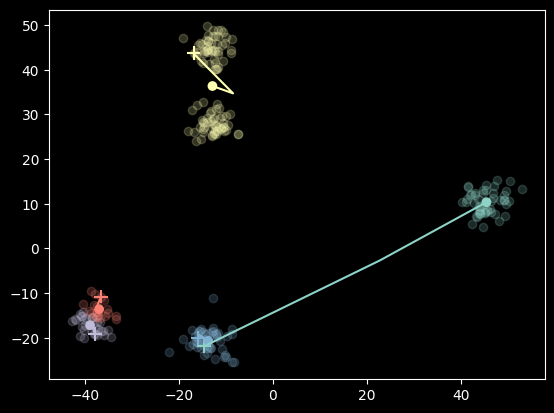

In [36]:

centroids, regions, errors, pathX, pathY, init=k_means(k, data)

for i in range(len(regions)):
    xr=[regions[i][j][0] for j in range(len(regions[i]))]
    yr=[regions[i][j][1] for j in range(len(regions[i]))]
    label = "region " + str(i)
    plt.scatter(xr, yr, alpha=0.2, label=label)
    
xct=[init[i][0] for i in range(len(init))]
yct=[init[i][1] for i in range(len(init))]
#plt.scatter(xc, yc, color="r", label="Cluster Centres")
plt.scatter(xct, yct, s=100, marker="+", c=cycle[:len(xct)], label="Centroides")    

xct=[centroids[i][0] for i in range(len(init))]
yct=[centroids[i][1] for i in range(len(init))]
plt.scatter(xct, yct, marker="o", c=cycle[:len(xct)], label="Centroids")

for i in range(k):
    plt.plot(pathX[i], pathY[i])


Enfin, on trace le cout du clustering pour chaque iteration de l'algorithme *k-mean*.

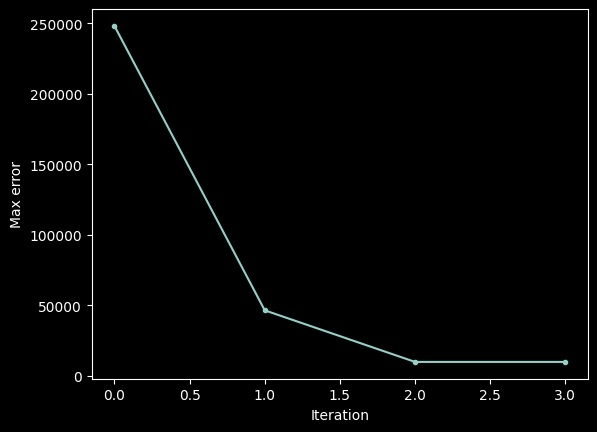

In [37]:
# l'erreur entre les centroides et les données  centre des clusters connu (par génération des données)

plt.plot(errors, ".-")
plt.xlabel("Iteration")
plt.ylabel("Max error")

plt.show()


>**Question 7**
>
>
>Essayer de lancer la fonction avec un nombre de clusters recherchés différents du nombre utlisé à la création des clusters (ex : on cherche 5 clusters alors qu'on en a créé 3 dans notre jeu de données)

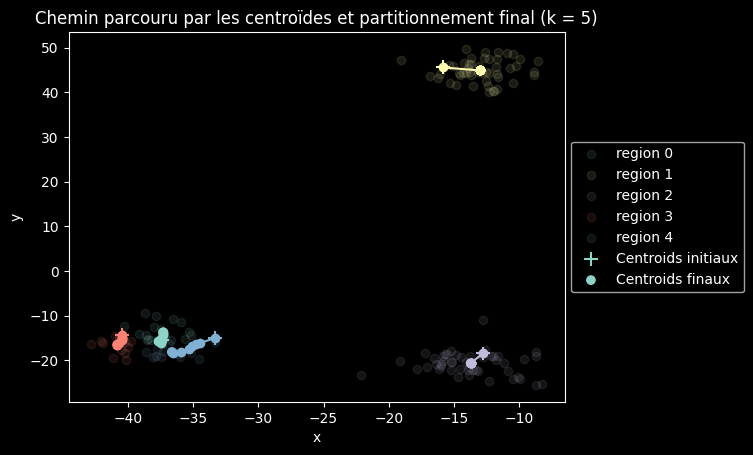

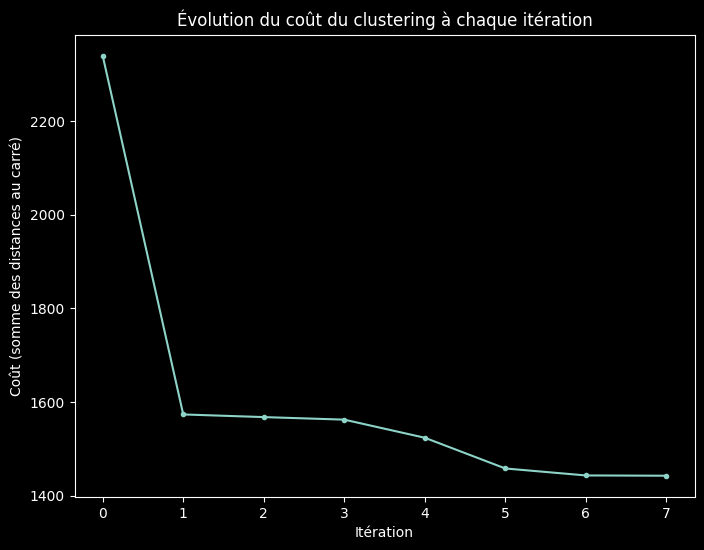

In [38]:
nclusters = 3
sizes = 50 * np.ones(nclusters, int)

clusters, centers = clusters_func(sizes)
data = np.reshape(clusters, (-1, clusters.shape[-1]))

k_search = 5

centroids, regions, errors, pathX, pathY, init = k_means(k_search, data)

for i in range(len(regions)):
    xr = [regions[i][j][0] for j in range(len(regions[i]))]
    yr = [regions[i][j][1] for j in range(len(regions[i]))]
    label = f"region {i}"
    plt.scatter(xr, yr, alpha=0.1, label=label)

xct_init = [init[i][0] for i in range(len(init))]
yct_init = [init[i][1] for i in range(len(init))]
plt.scatter(xct_init, yct_init, s=100, marker="+", c=cycle[:len(init)], label="Centroids initiaux")

xct = [centroids[i][0] for i in range(len(centroids))]
yct = [centroids[i][1] for i in range(len(centroids))]
plt.scatter(xct, yct, marker="o", c=cycle[:len(xct)], label="Centroids finaux")

for i in range(k_search):
    plt.plot(pathX[i], pathY[i], marker="o")

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Chemin parcouru par les centroïdes et partitionnement final (k = {k_search})")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(errors, ".-")
plt.xlabel("Itération")
plt.ylabel("Coût (somme des distances au carré)")
plt.title("Évolution du coût du clustering à chaque itération")
plt.show()


## 2 - Application sur un jeu de données classique : the Iris Dataset


In [39]:
from sklearn import datasets

# chargement de base de données iris
iris = datasets.load_iris()
#print(iris)
#print(iris.data)
print(iris.feature_names)
#print(iris.target)
print(iris.target_names)


# On ne va prendre que la longueur et largeur des pétales comme critères de clustering (pour être en deux dimensions)
data = []
for i in range(len(iris.data)):
    subData = [iris.data[i][2], iris.data[i][3]]
    data.append(subData)
data = np.asarray(data)
#print(data)

    

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


>__Question 8__ Appliquer l'algorithme k-means sur ces données et représenter visuellement le résultat 

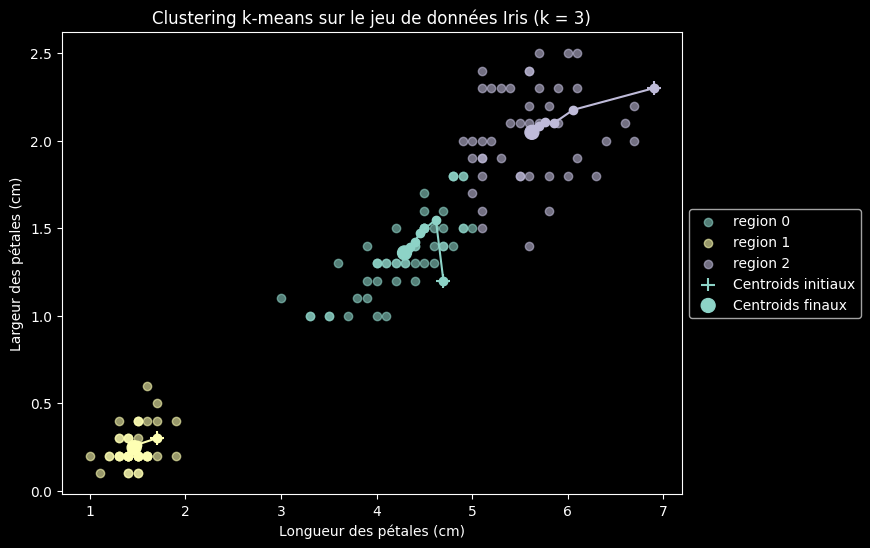

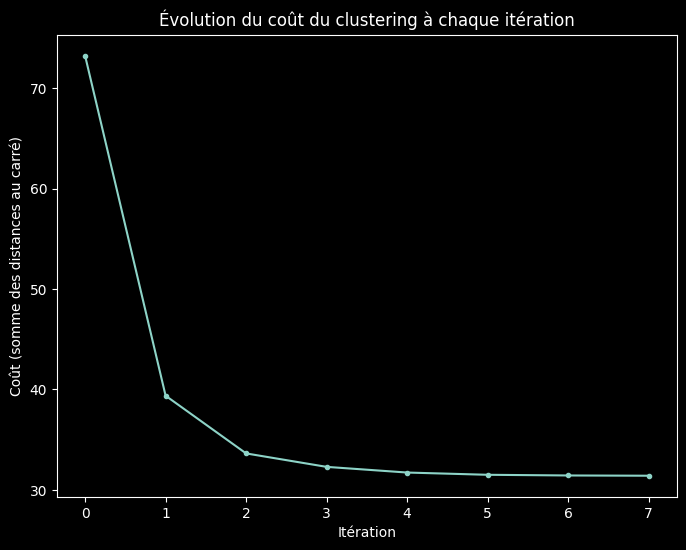

In [40]:
k_search = 3  # Il y a 3 espèces d'iris, donc on cherche 3 clusters

centroids, regions, errors, pathX, pathY, init = k_means(k_search, data)

plt.figure(figsize=(8, 6))
for i in range(len(regions)):
    xr = [regions[i][j][0] for j in range(len(regions[i]))]
    yr = [regions[i][j][1] for j in range(len(regions[i]))]
    label = f"region {i}"
    plt.scatter(xr, yr, alpha=0.6, label=label)

xct_init = [init[i][0] for i in range(len(init))]
yct_init = [init[i][1] for i in range(len(init))]
plt.scatter(xct_init, yct_init, s=100, marker='+', c=cycle[:len(init)], label="Centroids initiaux")

xct = [centroids[i][0] for i in range(len(centroids))]
yct = [centroids[i][1] for i in range(len(centroids))]
plt.scatter(xct, yct, marker="o", c=cycle[:len(xct)], label="Centroids finaux", s=100)

for i in range(k_search):
    plt.plot(pathX[i], pathY[i], marker="o")

plt.xlabel("Longueur des pétales (cm)")
plt.ylabel("Largeur des pétales (cm)")
plt.title(f"Clustering k-means sur le jeu de données Iris (k = {k_search})")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(errors, ".-")
plt.xlabel("Itération")
plt.ylabel("Coût (somme des distances au carré)")
plt.title("Évolution du coût du clustering à chaque itération")
plt.show()


## 3 - Clustering de films et d'utilisateurs


Dans cette partie on se propose une première implémentation d'un clustering des données du sondage que vous avez rempli.

Le code a été récupéré sur internet (https://github.com/gouravaich/k-means-clustering-movie-ratings/blob/master/k-means%20Clustering%20of%20Movie%20Ratings.ipynb) ; puis adapté afin de fonctionner sur nos données.<br>


**À vous de l'améliorer et de l'analyser.**

In [41]:
# importation des packages
import pandas as pd
import seaborn as sns


import scipy.stats as sps
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [42]:
# importation du fichier
data = pd.read_csv("notes_films.tsv", sep="\t") # les données ont été un peu retouchées à la main
data.head()


,Numéro étudiant (pour traitement des données).,Aladdin,Aliens : Le Retour,Arrête-moi si tu peux,Avengers: Endgame,Blade Runner,Braveheart,Coco,Django Unchained,Eternal Sunshine of the Spotless Mind,...,The Grand Budapest hotel,The Truman Show,Toy Story,Trainspotting,Un homme d'exception,Un jour sans fin,Usual Suspects,V pour vendetta,WALL·E,Will Hunting
0,19162570,-1,-1,3.0,-1,-1,3.0,-1.0,4.0,-1,...,5,2,2.0,5,-1,-1,4.0,3,-1,1
1,565656,3,2,2.0,4,-1,-1.0,4.0,3.0,-1,...,4,4,4.0,-1,-1,-1,3.0,2,5,3
2,52000535,4,-1,5.0,4,-1,-1.0,3.0,-1.0,-1,...,-1,4,4.0,-1,-1,-1,5.0,-1,5,-1
3,1234567890,-1,-1,3.0,-1,-1,3.0,-1.0,4.0,-1,...,5,2,2.0,5,-1,2,4.0,3,-1,1
4,2001490,3,2,4.0,5,-1,-1.0,5.0,-1.0,-1,...,-1,-1,3.0,-1,-1,-1,-1.0,-1,3,-1


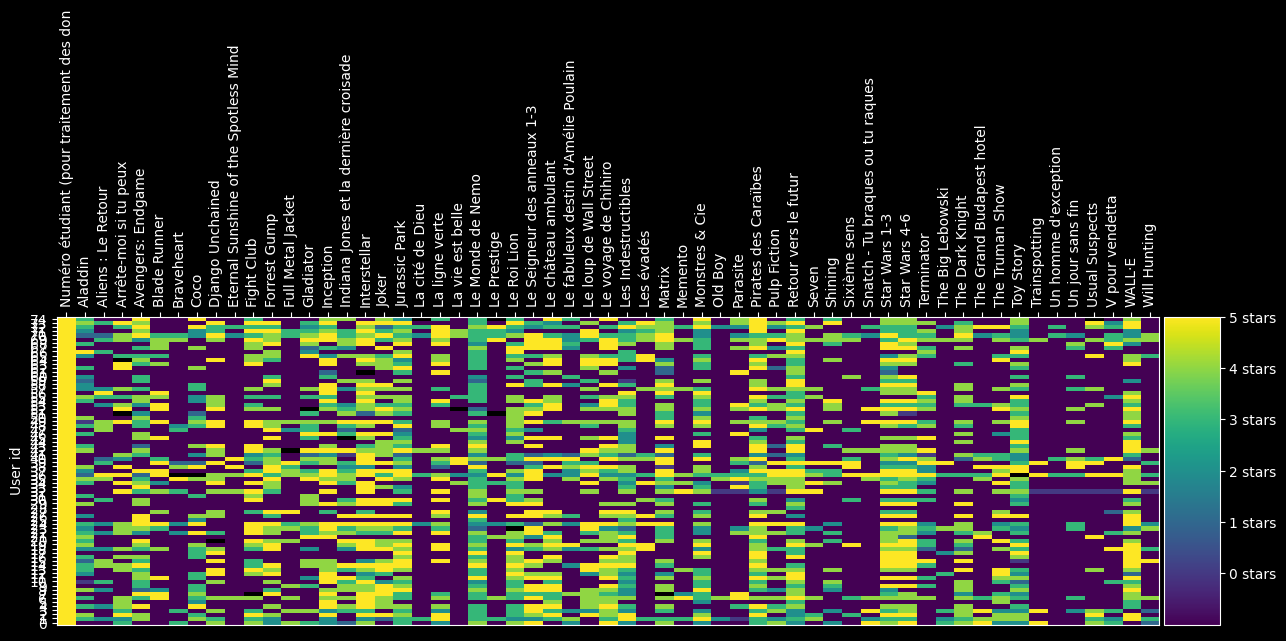

In [50]:
# https://github.com/gouravaich/k-means-clustering-movie-ratings/blob/master/k-means%20Clustering%20of%20Movie%20Ratings.ipynb

def draw_movie_clusters(clustered, max_users, max_movies):
    c = 1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(["index", "group"], axis=1)
        n_users_in_cluster = d.shape[0]
        
        #d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print("cluster # {}".format(cluster_id))
            print("# of users in cluster: {}.".format(n_users_in_cluster), "# of users in plot: {}".format(n_users_in_plot))
            fig = plt.figure(figsize=(15, 4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]), minor=False)
            ax.set_xticks(np.arange(d.shape[1]), minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect="auto")

            ax.set_xlabel("movies")
            ax.set_ylabel("User id")

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(["5 stars", "4 stars","3 stars",  "2 stars", "1 stars", "0 stars"])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis="both", which="both", bottom="off", top="off", left="off", labelbottom="off", labelleft="off") 
            #print("cluster # {} \n(Showing at most {} users and {} movies)".format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed : Pythonic way of achieving this
            # c = c + 1
            # if c > 6:
            
            
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15, 4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation="nearest", vmin=-1, vmax=5, aspect="auto")

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]), minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]), minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel("User id")

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(["5 stars", "4 stars", "3 stars", "2 stars", "1 stars", "0 stars"])



    plt.show()

draw_movies_heatmap(data)


cluster # 3
# of users in cluster: 23. # of users in plot: 20


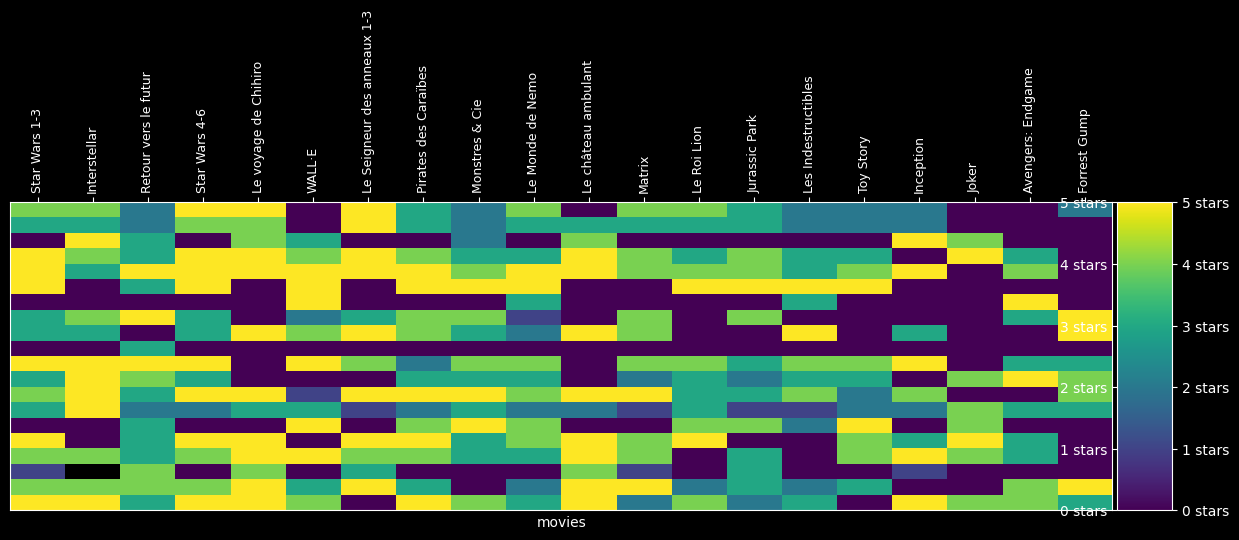

cluster # 4
# of users in cluster: 11. # of users in plot: 11


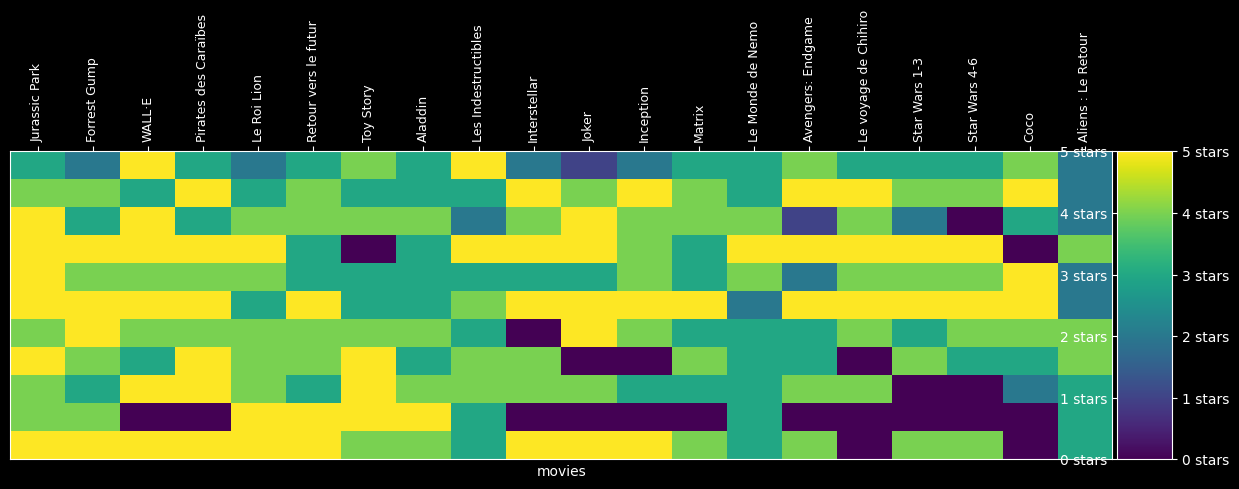

cluster # 0
# of users in cluster: 28. # of users in plot: 20


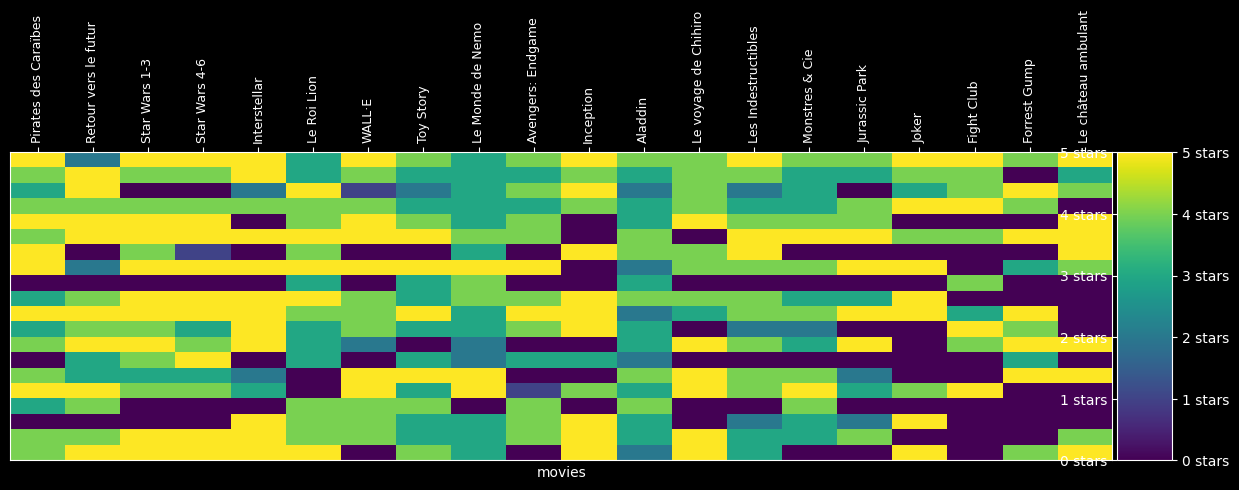

cluster # 2
# of users in cluster: 10. # of users in plot: 10


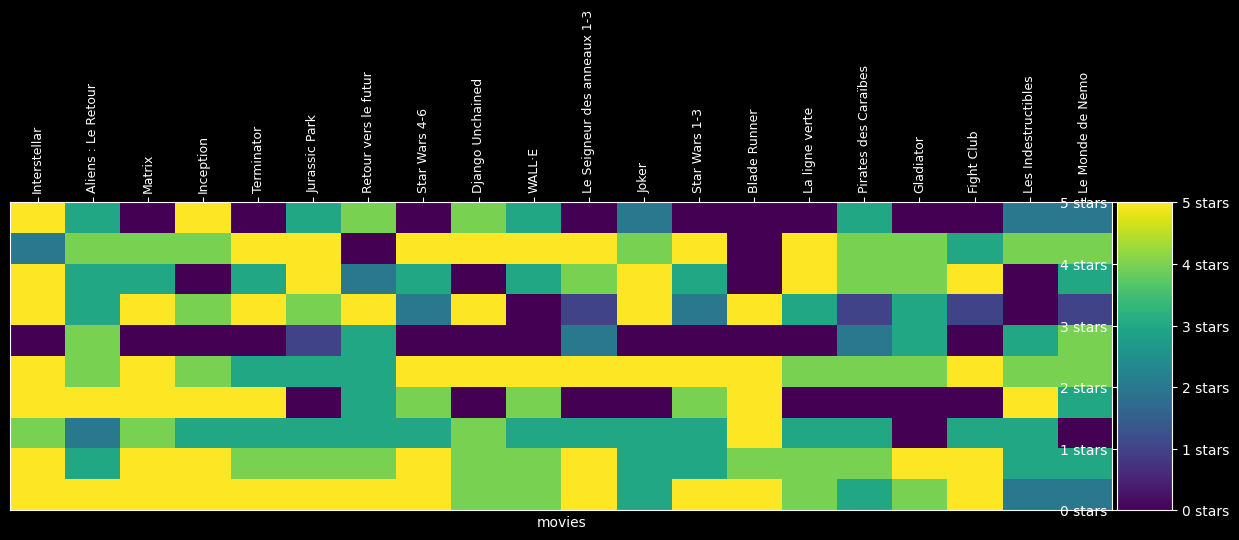

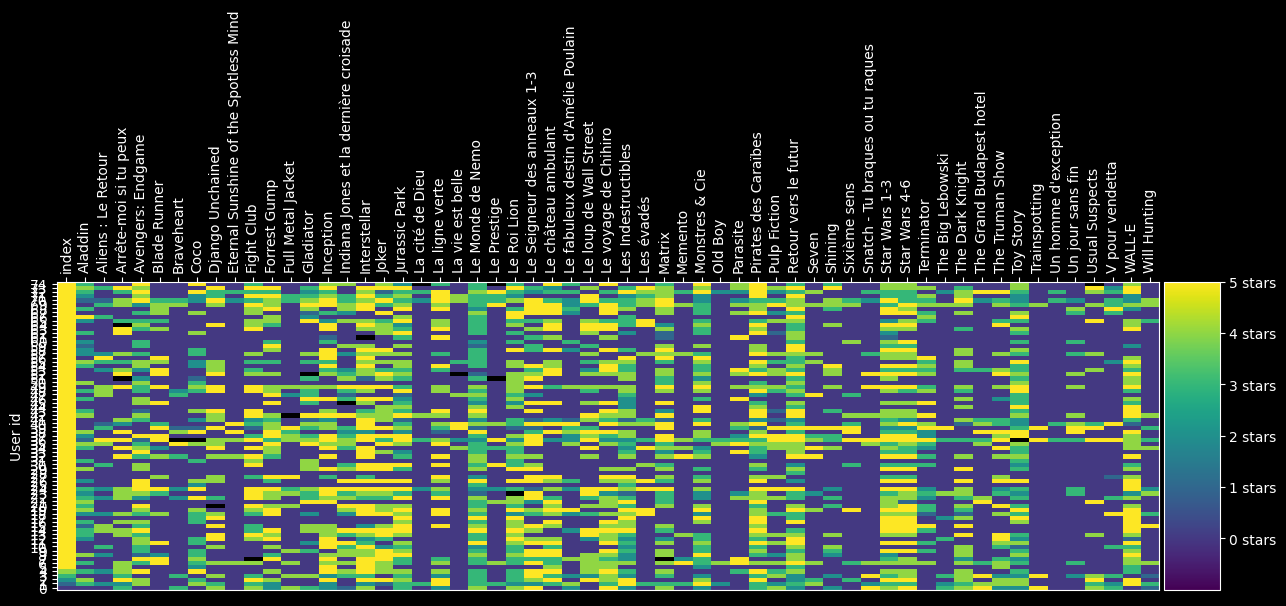

In [53]:
data_cleaned = data.replace(-1, 0)
data_cleaned = data_cleaned.drop(columns=["Numéro étudiant (pour traitement des données)."])
data_matrix = data_cleaned.to_numpy()

def regions_update(k, data, centroids):
    regions = [[] for _ in range(k)]
    for idx, point in enumerate(data):
        distances = [distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        regions[closest_centroid].append(idx)  # Stocker les indices des utilisateurs
    return regions


def centroids_update(data, centroids, regions):
    centroids_new = []  # Liste pour stocker les nouveaux centroïdes
    diffs = []  # Liste pour stocker les déplacements
    
    for i in range(len(centroids)):
        # Si une région est vide, choisir un point aléatoire parmi les données pour ce centroïde
        if len(regions[i]) == 0:
            new_centroid = data[np.random.randint(0, len(data))]
        else:
            # Obtenir les points correspondant aux indices des utilisateurs dans la région
            points_in_region = data[regions[i]]
            
            # Calculer le barycentre des points de la région
            new_centroid = np.mean(points_in_region, axis=0)
        
        # Calculer la distance entre l'ancien et le nouveau centroïde
        diff = distance(centroids[i], new_centroid)
        diffs.append(diff)
        
        # Ajouter le nouveau centroïde à la liste
        centroids_new.append(new_centroid)
    
    # Calculer la distance maximale de déplacement
    max_diff = max(diffs)
    
    return np.array(centroids_new), max_diff


def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def k_means(k, data, stop_diff=1e-3):
    centroids = init_centroid_donnees(k, data)
    init = centroids.copy()  # Sauvegarder les centroïdes initiaux pour la visualisation
    pathX, pathY = [[] for _ in range(k)], [[] for _ in range(k)]
    errors = []  # Pour suivre l'évolution du coût à chaque itération
    
    while True:
        # Mise à jour des régions : assigner chaque point au centroïde le plus proche
        regions = regions_update(k, data, centroids)
        
        # Mise à jour des centroïdes : recalculer les centroïdes
        new_centroids, max_diff = centroids_update(data, centroids, regions)
        
        for i in range(k):
            pathX[i].append(centroids[i][0])
            pathY[i].append(centroids[i][1])
        
        # Calcul du coût (somme des distances au carré des points à leur centroïde)
        cost = 0
        for i in range(k):
            for user_index in regions[i]:
                point = data[user_index]  # Utiliser les données de l'utilisateur
                cost += distance(point, centroids[i]) ** 2
        errors.append(cost)
        
        # Critère d'arrêt : si les centroïdes ne bougent plus beaucoup, on arrête
        if max_diff < stop_diff:
            break
        
        # Mise à jour des centroïdes pour la prochaine itération
        centroids = new_centroids
    
    return centroids, regions, errors, pathX, pathY, init


k_clusters = 5
centroids, regions, errors, pathX, pathY, init = k_means(k_clusters, data_matrix)


# Assigner les groupes (clusters) aux données originales
data_cleaned["group"] = [None] * data_cleaned.shape[0]
for i, region in enumerate(regions):
    for user_index in region:  # Utiliser les indices des utilisateurs
        data_cleaned.at[user_index, "group"] = i

# Visualiser les clusters
data_cleaned = data_cleaned.reset_index()
draw_movie_clusters(data_cleaned, max_users=20, max_movies=20)

# Visualisation générale des notes avec une heatmap
draw_movies_heatmap(data_cleaned.drop(columns=["group"]), axis_labels=True)
